# Evaluation NER - Sorties HTR brutes

## Cas d'usage - indexation automatique des noms de personne et d'organisation des enregistrements des pages des répertoires de notaires

Pour se rendre compte de l'efficacité et la régularité du NER, on peut observer chaque première entité de chaque enregistrement. Dans le cas de LECTAUREP, celles-ci doivent nécessairement être une `PER` (personne) ou une `ORG` (organisation). Si l'extraction est régulière, on peut envisager le cas d'une indexation automatique des noms de personnes et d'organisations présents dans les répertoires de notaires.

Dans cette expérience, on mesurera donc cette régularité en fonction du score de CER, sur une seule et même page.

Le CER a été obtenu en appliquant plusieurs modèles d'HTR et grâce à la librairie [KaMI](https://gitlab.inria.fr/dh-projects/kami/kami-lib).

L'expérience a été réalisée une première fois, on la recommence sur une page plus dense, avec donc plus d'enregistrements.

## Imports et modèle de langue

In [1]:
from pathlib import Path
import re

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import spacy

 On charge le [modèle de langue française](https://spacy.io/models/fr#fr_core_news_lg) de spaCy.

In [2]:
nlp_pipeline_fr = spacy.load("fr_core_news_lg")

## Fonctions utilisées pour les tests

Pour le pré-traitement, on utilise la segmentation des régions et l'annotation sémantique des baselines d'eScriptorium.

On récupère la colonne 5, et on crée une liste qui contiendra un enregistrement par index.

`[enregistrement 1, enregistrement 2, enregistrement 3]`

Chaque index passera dans la pipeline NLP.

On essaye également de corriger l'HTR en séparant les mots aglutinés à l'aide des majuscules, et en utilisant des regex.

In [3]:
def open_and_parse(source):
    '''open a file and parsed its content with BeautifulSoup'''
    with open(source, 'r', encoding='utf8') as fh:
        file_content = fh.read()
    parsed_source = BeautifulSoup(file_content, 'xml')
    return parsed_source


def split_word_on_caps(orig):
    '''
    Spots words stuck together and split them using regex
    
    e.g. thisIsAnExample --> this Is An Example
    '''
    
    # word segmentation using regex
    # regex are based on study of LECTAUREP's textual data and its recurrent errors
    letter_before_caps_splitted = re.sub(r"(\w)([A-Z])", r"\1 \2", orig)
    # undo previous correction of an abbreviation used in the répertoires de notaires
    correction_abbreviated_sson = re.sub("S Son", "SSon", letter_before_caps_splitted)
    blank_space_address_number = re.sub(r'(\d{2})([A-z])', r'\1 \2', correction_abbreviated_sson)
    special_character_before_caps_splitted = re.sub(r"(\))([A-Z])", r"\1 \2", blank_space_address_number)
    blank_space_address = re.sub("del'", "de l'", special_character_before_caps_splitted)
    blank_space_ruede = re.sub("ruede", "rue de", blank_space_address)
    blank_space_ruedu = re.sub("ruedu", "rue du", blank_space_ruede)
    blank_space_ruedela = re.sub("ruedela", "rue de la", blank_space_ruedu)
    blank_space_sondomicile = re.sub("sondomicile", "son domicile", blank_space_ruedela)
    blank_space_beginning_date = re.sub("([A-z])([1-9])", r"\1 \2", blank_space_sondomicile)
    blank_space_month_year = re.sub(r"([A-z])(\d{3,4})", r"\1 \2", blank_space_beginning_date)
    blank_space_before_parenthesis = re.sub(r"([A-z])(\()", r"\1 \2", blank_space_month_year)
    # First encoding for à : \xc3\xa0
    blank_space_before_à = re.sub(r"([^l\s])(à)", r"\1 \2", blank_space_before_parenthesis)
    blank_space_after_à = re.sub(r"(à)([A-z])", r"\1 \2", blank_space_before_à)
    # Second encoding for à : a\xcc\x80
    blank_space_before_à_2 = re.sub(r"([^l\s])(à)", r"\1 \2", blank_space_after_à)
    blank_space_after_à_2 = re.sub(r"(à)([A-z])", r"\1 \2", blank_space_before_à_2)

    return blank_space_after_à_2


def get_transcription_list(xml_tree):
    '''find text nodes in PAGE XML and get them ready for NER processing'''
    transcriptions = []
    col_5 = xml_tree.find_all('TextRegion', custom="structure {type:col_5;}")
    
    for col in col_5:
        baselines = col.find_all('TextLine')
        for baseline in baselines:
            if baseline.has_attr('custom'):
                if baseline['custom'] == 'structure {type:first_line;}':
                    transcriptions.append([baseline.text.strip('\n')])
            else:
                transcriptions[-1].append(baseline.text.strip('\n'))
                
    transcriptions = [[' '.join(transcription)] for transcription in transcriptions]
    transcriptions_flat_list = [entry for sublist in transcriptions for entry in sublist]
                    
    return transcriptions_flat_list

## Fonctions de visualisation

In [4]:
def show_entities(nlp_processed_text):
    '''for each entry in a page, show the entry and its named entities'''
    for enregistrement in nlp_processed_text:
        print(enregistrement)
        print('\n')
        for ent in enregistrement.ents:
            print(ent.text, ent.label_)
        print('_________ \n')
        
        
def show_ner_prediction_nb(nlp_processed_text):
    '''based on NER prediction, show how many named entities were recognized in a page'''
    ent_count = 0
    for enregistrement in nlp_processed_text:
        ent_count += len(enregistrement.ents)
    print(f'Prédiction NER : {ent_count} entités nommées')
    
    return ent_count

### Métriques

Pour une page avec 18 entrées, on devrait pouvoir retrouver 18 entités `ORG` ou `PER` en première place. 

Avec ces données, on peut ainsi calculer l'accuracy de la façon de suivante :

$$
\frac{y}{x} \times 100 = P
$$

Où $y$ correspond au nombre d'entités correctement labellisées en tant que PER ou ORG, et $x$ au nombre d'enregistrements.

L'accuracy nous indique le pourcentage de bonnes prédictions.

In [5]:
def how_many_entries(transcription):
    '''count how many entries are there in a list'''
    return len(transcription)

def count_per_org(processed_transcriptions):
    '''return how many first tokens for each entry are PER or ORG'''
    count_per_org = 0
    for enregistrement in processed_transcriptions:
        ent_list = []
        if enregistrement.ents:
            for ent in enregistrement.ents:
                ent_list.append(ent.label_)
            if ent_list[0] == 'PER' or ent_list[0] == 'ORG':
                count_per_org += 1
            
    return count_per_org

def compute_accuracy(correct_entities, nb_entries):
    '''compute accuracy'''
    return correct_entities / nb_entries * 100

## CER 0%

In [6]:
source_cer_0 = "../../corpus_test/lectaurep/ner_test_first_token/img_2/pagexml/cer_0/FRAN_0025_0029_L-0.xml"
content_cer_0 = open_and_parse(source_cer_0)
sample_cer_0 = get_transcription_list(content_cer_0)
sample_splitted_cer_0 = [split_word_on_caps(entry) for entry in sample_cer_0]

In [7]:
sample_splitted_cer_0

['Dupuis, (par Pierre) à Paris, rue Turgot 4, à Catherine Bizial, sa femme',
 '- d° - (par Mme) s. n. à son mari',
 'Murel (par Paul Louis Georges) dt à Paris, Bd Rochechouart 68, et Marie Joséphine Lemaire, dt à Paris, même adresse (Séparation de biens)',
 'Dubosc (ct titre de 380+ de rente 3% au nom  de\xa0: Debuisson, Justine Adèle, Vve de Jules) et autres, à Paris, rue de l’Arcade 20',
 'Rouy (par Edmond Narcisse), dt à Paris, rue Cavalotti 15, et autres, pr toucher &amp; recevoir',
 'Chabrol (par Marie Louise Vatonne, Ve de Marie Eusèbe Maxime) dt à Billancourt, route de  Versailles, 128, à Eugène Vatrin et Marceline Freling, dt à Billancourt, rue Nationale 31, de 21 303,88',
 'Gauthier (par Marie Alexandrine) à Paris, rue St Ferdinand 2, à ses père et mère',
 'Cusson (par Georges Ernest Léon) dt à Paris, rue Lamarck 144, à son père',
 'Lecrosnier (ct livret de caisse d’Epargne de Paris, de 157,19 au nom de Pierre Auguste) décédé en son domicile à Paris, rue Descartes 21, le 16 8b

In [8]:
sample_processed_cer_0 = [nlp_pipeline_fr(str(enregistrement)) for enregistrement in sample_splitted_cer_0]

In [9]:
show_entities(sample_processed_cer_0)

Dupuis, (par Pierre) à Paris, rue Turgot 4, à Catherine Bizial, sa femme


Dupuis ORG
Pierre MISC
Paris LOC
rue Turgot LOC
Catherine Bizial PER
_________ 

- d° - (par Mme) s. n. à son mari


Mme PER
_________ 

Murel (par Paul Louis Georges) dt à Paris, Bd Rochechouart 68, et Marie Joséphine Lemaire, dt à Paris, même adresse (Séparation de biens)


Murel MISC
Paul Louis Georges PER
Paris LOC
Marie Joséphine Lemaire PER
Paris LOC
Séparation MISC
_________ 

Dubosc (ct titre de 380+ de rente 3% au nom  de : Debuisson, Justine Adèle, Vve de Jules) et autres, à Paris, rue de l’Arcade 20


Dubosc PER
Debuisson PER
Justine Adèle PER
Vve de Jules PER
Paris LOC
rue de l’Arcade 20 LOC
_________ 

Rouy (par Edmond Narcisse), dt à Paris, rue Cavalotti 15, et autres, pr toucher &amp; recevoir


Rouy LOC
Edmond Narcisse PER
Paris LOC
Cavalotti 15 MISC
_________ 

Chabrol (par Marie Louise Vatonne, Ve de Marie Eusèbe Maxime) dt à Billancourt, route de  Versailles, 128, à Eugène Vatrin et Marceline 

In [10]:
entity_count_cer_0 = show_ner_prediction_nb(sample_processed_cer_0)

Prédiction NER : 171 entités nommées


In [11]:
nb_entries_cer_0 = how_many_entries(sample_cer_0)
nb_per_org_cer_0 = count_per_org(sample_processed_cer_0)
accuracy_cer_0 = compute_accuracy(nb_per_org_cer_0, nb_entries_cer_0)

In [12]:
print(f'Nombre d\'enregistrements présents sur la page : {nb_entries_cer_0} \t Nombre de premières entités étant PER ou ORG : {nb_per_org_cer_0}')

print(f'Accuracy : {accuracy_cer_0}')

Nombre d'enregistrements présents sur la page : 33 	 Nombre de premières entités étant PER ou ORG : 21
Accuracy : 63.63636363636363


## CER 14%

In [13]:
source_cer_14 = "../../corpus_test/lectaurep/ner_test_first_token/img_2/pagexml/cer_14/FRAN_0025_0029_L-0.xml"
content_cer_14 = open_and_parse(source_cer_14)
sample_cer_14 = get_transcription_list(content_cer_14)
sample_splitted_cer_14 = [split_word_on_caps(entry) for entry in sample_cer_14]

In [14]:
sample_splitted_cer_14

['Dupuis (par Pierre) à Paris, rue Turgot 4, à Catherine Bizjat, safeu',
 '-do- (par M^me) s. n. à',
 'Muret (de Paul Louis Georges) dt à Paris, Bd Rochechouart 68, et Marie Joséphine Lemaire, dt à Paris, même adresse (Séparation debiens)',
 "Duboscq (ct titre de 380 f de rente 3% au nom de: Debuiston, Justine Adèle Ve de Sules) et autres, à Paris, rue de l'Arcade 21",
 'Rouy (par Edmond Marcisse) dt à Paris, rue Cavalotti 15, et autres, pr tonchor 2 marie',
 'Chabrot (par Marie Louise Jatonne, Ve de Marie Eusèbe Mascime) dt à Billancourt, route de Versailles, 178, à Eugène Jatrin et Marceline Freling, dt à Billancourt, rue Nationale 31, de 21303,88',
 'Gauthier (par Marie Alexandrine) à Paris, rue St Ferdinand 2, à ses père et mère',
 'Cusson (par Georges Ernest Léon) dt àParis, rue Lamarck 144, à son père',
 "Lecrosnier (tlivret de Caisse d'Epargne de Paris, de 157.19, au nom de Pierre Auguste) décèdé en son domicile à Paris, rue Descartes 21, le 16 8^bre 

In [15]:
sample_processed_cer_14 = [nlp_pipeline_fr(str(enregistrement)) for enregistrement in sample_splitted_cer_14]

In [16]:
show_entities(sample_processed_cer_14)

Dupuis (par Pierre) à Paris, rue Turgot 4, à Catherine Bizjat, safeu


Dupuis ORG
Pierre MISC
Paris LOC
rue Turgot LOC
Catherine Bizjat PER
_________ 

-do- (par M^me) s. n. à


M^me MISC
_________ 

Muret (de Paul Louis Georges) dt à Paris, Bd Rochechouart 68, et Marie Joséphine Lemaire, dt à Paris, même adresse (Séparation debiens)


Muret LOC
Paul Louis Georges PER
Paris LOC
Marie Joséphine Lemaire PER
Paris LOC
Séparation debiens LOC
_________ 

Duboscq (ct titre de 380 f de rente 3% au nom de: Debuiston, Justine Adèle Ve de Sules) et autres, à Paris, rue de l'Arcade 21


Duboscq PER
Debuiston PER
Justine Adèle Ve de Sules PER
Paris LOC
rue de l'Arcade 21 LOC
_________ 

Rouy (par Edmond Marcisse) dt à Paris, rue Cavalotti 15, et autres, pr tonchor 2 marie


Rouy LOC
Edmond Marcisse PER
Paris LOC
Cavalotti 15 MISC
_________ 

Chabrot (par Marie Louise Jatonne, Ve de Marie Eusèbe Mascime) dt à Billancourt, route de Versailles, 178, à Eugène Jatrin et Marceline Frel

In [17]:
entity_count_cer_14 = show_ner_prediction_nb(sample_processed_cer_14)

Prédiction NER : 177 entités nommées


In [18]:
nb_entries_cer_14 = how_many_entries(sample_cer_14)
nb_per_org_cer_14 = count_per_org(sample_processed_cer_14)
accuracy_cer_14 = compute_accuracy(nb_per_org_cer_14, nb_entries_cer_14)

In [19]:
print(f'Nombre d\'enregistrements présents sur la page : {nb_entries_cer_14} \t Nombre de premières entités étant PER ou ORG : {nb_per_org_cer_14}')

print(f'Accuracy : {accuracy_cer_14}')

Nombre d'enregistrements présents sur la page : 33 	 Nombre de premières entités étant PER ou ORG : 15
Accuracy : 45.45454545454545


## CER 17% (1)

In [20]:
source_cer_17 = "../../corpus_test/lectaurep/ner_test_first_token/img_2/pagexml/cer_17_1/FRAN_0025_0029_L-0.xml"
content_cer_17 = open_and_parse(source_cer_17)
sample_cer_17 = get_transcription_list(content_cer_17)
sample_splitted_cer_17 = [split_word_on_caps(entry) for entry in sample_cer_17]

In [21]:
sample_splitted_cer_17

['Dupuis (par Pierre) à Paris, rue Turgot 4, à Eatherine Bizal, safeumn',
 'd° - (par Mme s. n. à',
 'Muret (de Paul Louis Georges) dt à Paris, Bd Rochechouart 68, et Marie Joséphine Lemaire, dt à Paris, même adresse (Séparation debiens',
 "Duboscq (S titre de 380 f de rente 3% au nom de. Debuisson, Justine Adèle, Se de Jules) et autres, à Paris, rue de l'Arcade 26",
 "Rouypar Edmondtareisse) dt à Paris, rue Cavalott 15, et autres pr Mouchar V'unarie",
 'Chabrol (par Marie Louise atonne, Ve de Marie Ensèbe Maseime) dt à Billancourt, route de Versailles, 178, à Eugène Jatrin et Marceline Frelinq, dt à Billancourt, rue Natiouale 31, de 21303,88.',
 'Gauthier (par Marie Alexandrine) à Paris, rue St Ferdinand 2, à sespère et mère',
 'Ousson (par Geordes Trnest Léon) dt à Paris, rue Lamarck 144, à son père',
 "Lecrosnier (Lvretde Caisse d'Tpargne de Paris, de 157.19, au nom de Pierre Auguste) décédé en son domicile à Paris, rue Descartes 21, le 16 8bre 1900",
 'C

In [22]:
sample_processed_cer_17 = [nlp_pipeline_fr(str(enregistrement)) for enregistrement in sample_splitted_cer_17]

In [23]:
show_entities(sample_processed_cer_17)

Dupuis (par Pierre) à Paris, rue Turgot 4, à Eatherine Bizal, safeumn


Dupuis ORG
Pierre MISC
Paris LOC
rue Turgot LOC
Eatherine Bizal PER
_________ 

d° - (par Mme s. n. à


Mme PER
_________ 

Muret (de Paul Louis Georges) dt à Paris, Bd Rochechouart 68, et Marie Joséphine Lemaire, dt à Paris, même adresse (Séparation debiens


Muret LOC
Paul Louis Georges PER
Paris LOC
Marie Joséphine Lemaire PER
Paris LOC
Séparation debiens LOC
_________ 

Duboscq (S titre de 380 f de rente 3% au nom de. Debuisson, Justine Adèle, Se de Jules) et autres, à Paris, rue de l'Arcade 26


Duboscq PER
S LOC
Debuisson PER
Justine Adèle PER
Se de Jules MISC
Paris LOC
rue de l'Arcade 26 LOC
_________ 

Rouypar Edmondtareisse) dt à Paris, rue Cavalott 15, et autres pr Mouchar V'unarie


Rouypar Edmondtareisse PER
Paris LOC
rue Cavalott 15 LOC
Mouchar V' MISC
_________ 

Chabrol (par Marie Louise atonne, Ve de Marie Ensèbe Maseime) dt à Billancourt, route de Versailles, 178, à Eugène Jatrin 

In [24]:
entity_count_cer_17 = show_ner_prediction_nb(sample_processed_cer_17)

Prédiction NER : 179 entités nommées


In [25]:
nb_entries_cer_17 = how_many_entries(sample_cer_17)
nb_per_org_cer_17 = count_per_org(sample_processed_cer_17)
accuracy_cer_17 = compute_accuracy(nb_per_org_cer_17, nb_entries_cer_17)

In [26]:
print(f'Nombre d\'enregistrements présents sur la page : {nb_entries_cer_17} \t Nombre de premières entités étant PER ou ORG : {nb_per_org_cer_17}')

print(f'Accuracy : {accuracy_cer_17}')

Nombre d'enregistrements présents sur la page : 33 	 Nombre de premières entités étant PER ou ORG : 17
Accuracy : 51.515151515151516


## CER 17% (2)

On teste sur une autre transcription à 17% de CER, produite avec un autre modèle, donc possédant des fautes différentes.

In [27]:
source_cer_17_2 = "../../corpus_test/lectaurep/ner_test_first_token/img_2/pagexml/cer_17_2/FRAN_0025_0029_L-0.xml"
content_cer_17_2 = open_and_parse(source_cer_17_2)
sample_cer_17_2 = get_transcription_list(content_cer_17_2)
sample_splitted_cer_17_2 = [split_word_on_caps(entry) for entry in sample_cer_17_2]

In [28]:
sample_splitted_cer_17_2

['Dupuis (par Pierre) à Paris, rue Eurgot 4, à Cctherine Bizjel, safeue',
 'd°- par M^me S. n. à',
 'Muret (de Paul Louis Georges) d^t à Paris, B^d Rochechouart 68, et Marie Joséphine Lemaire, d^t à Paris, même adresse Séparation de biens',
 "Duboscq (et titre de 380 ^f de rente 36 au nom de. Debuisson, Justine Adèle V^e de Pules) et antres, à Paris, rue de l'Arcade 26",
 "Rouypar Edmond Marcisse d^t à Paris, rue Cavalotti 15, et antres, p^r fonchor V'un ani",
 'Chabrol (par Marie Louise Jatonne, V^e de Marie Eusèbe Mascime d^t à Billancourt, route de Versailles, 178, à Eugène Jatrin et Marceline Frelina, d^t à Billancourt, rue Nationale 31, de 21303,88',
 'Gauthier (par Marie Alexandrile) à Paris, rue S^t Ferdinaid 2, à ses père et mère',
 'Cusson (par Georges Ernest Léon d^t à Paris, rue Lamarch 144, à son père',
 "Lecrosnier (etlivret de Caisse d'pargne de Paris, de 157.19, au nom de Pierre Auguste décédé en son domicile à Paris, rue Descartes 21, le 16 8

In [29]:
sample_processed_cer_17_2 = [nlp_pipeline_fr(str(enregistrement)) for enregistrement in sample_splitted_cer_17_2]

In [30]:
show_entities(sample_processed_cer_17_2)

Dupuis (par Pierre) à Paris, rue Eurgot 4, à Cctherine Bizjel, safeue


Dupuis ORG
Pierre MISC
Paris LOC
rue Eurgot LOC
Cctherine Bizjel PER
_________ 

d°- par M^me S. n. à


M^me PER
_________ 

Muret (de Paul Louis Georges) d^t à Paris, B^d Rochechouart 68, et Marie Joséphine Lemaire, d^t à Paris, même adresse Séparation de biens


Muret LOC
Paul Louis Georges PER
Paris LOC
B^d LOC
Marie Joséphine Lemaire PER
Paris LOC
_________ 

Duboscq (et titre de 380 ^f de rente 36 au nom de. Debuisson, Justine Adèle V^e de Pules) et antres, à Paris, rue de l'Arcade 26


Duboscq PER
^f LOC
Debuisson PER
Justine Adèle PER
Pules LOC
Paris LOC
rue de l'Arcade 26 LOC
_________ 

Rouypar Edmond Marcisse d^t à Paris, rue Cavalotti 15, et antres, p^r fonchor V'un ani


Rouypar LOC
Edmond Marcisse PER
Paris LOC
Cavalotti 15 MISC
p^r fonchor MISC
_________ 

Chabrol (par Marie Louise Jatonne, V^e de Marie Eusèbe Mascime d^t à Billancourt, route de Versailles, 178, à Eugène Jatrin et Mar

In [31]:
entity_count_cer_17_2 = show_ner_prediction_nb(sample_processed_cer_17_2)

Prédiction NER : 183 entités nommées


In [32]:
nb_entries_cer_17_2 = how_many_entries(sample_cer_17_2)
nb_per_org_cer_17_2 = count_per_org(sample_processed_cer_17_2)
accuracy_cer_17_2 = compute_accuracy(nb_per_org_cer_17_2, nb_entries_cer_17_2)

In [33]:
print(f'Nombre d\'enregistrements présents sur la page : {nb_entries_cer_17_2} \t Nombre de premières entités étant PER ou ORG : {nb_per_org_cer_17_2}')

print(f'Accuracy : {accuracy_cer_17_2}')

Nombre d'enregistrements présents sur la page : 33 	 Nombre de premières entités étant PER ou ORG : 19
Accuracy : 57.57575757575758


## CER 21%

In [34]:
source_cer_21 = "../../corpus_test/lectaurep/ner_test_first_token/img_2/pagexml/cer_21/FRAN_0025_0029_L-0.xml"
content_cer_21 = open_and_parse(source_cer_21)
sample_cer_21 = get_transcription_list(content_cer_21)
sample_splitted_cer_21 = [split_word_on_caps(entry) for entry in sample_cer_21]

In [35]:
sample_splitted_cer_21

['Dupuis (par Pierre) à Paris, rue Turot 4, à Catherine Bigol, safen',
 'a Oo (par Mve) s.n. à',
 'Muret (de Paul Louis Georges) dt à Paris, Bd Rochechouart 68, et Marie Joséphine Lemaire, dt à Paris, même adreré (Sléparation de biens',
 "Duboscqfet titre de 380+. de rente 3% au nom de: Debuisson, Juatine Adèle Se de Pnles) et autres, à Paris, rue de l'Orcade 21",
 'Rousfpa Pdmord Harcisse Bt a Paris, rue Canaletti 15, et autrespr touchor V',
 'Chabr (par Marie Louise Jatoune, Ve de Marie Eusébe Maseine Bt à Billancourt ronte de Sersailles. 18, à Ougène Vahrin et Marceline Fhalino, dt à Billancourt, rue Mationale 31, de 21303.88',
 'Gauther (par Marie Cexandinte) à Paris, rue St Ferdinandt, à sespère et mère',
 'Oussonppar Geordes Ernert Léou dt à Paris, rue Lamarch 144, à sonpère',
 "Lecrosnier (etlivret de Caistte d'Epargne de Paris, de 157.19, aunonde Pierre Pugute) décédé en son domicilé à P Paris, rue Descartes 21, le 16 8bre 1900",
 'Lettéronctlespie

In [36]:
sample_processed_cer_21 = [nlp_pipeline_fr(str(enregistrement)) for enregistrement in sample_splitted_cer_21]

In [37]:
show_entities(sample_processed_cer_21)

Dupuis (par Pierre) à Paris, rue Turot 4, à Catherine Bigol, safen


Dupuis ORG
Pierre MISC
Paris LOC
rue Turot LOC
Catherine Bigol PER
_________ 

a Oo (par Mve) s.n. à


Oo LOC
Mve LOC
_________ 

Muret (de Paul Louis Georges) dt à Paris, Bd Rochechouart 68, et Marie Joséphine Lemaire, dt à Paris, même adreré (Sléparation de biens


Muret LOC
Paul Louis Georges PER
Paris LOC
Marie Joséphine Lemaire PER
Paris LOC
Sléparation PER
_________ 

Duboscqfet titre de 380+. de rente 3% au nom de: Debuisson, Juatine Adèle Se de Pnles) et autres, à Paris, rue de l'Orcade 21


Debuisson LOC
Juatine Adèle PER
Pnles LOC
Paris LOC
rue de l' LOC
Orcade LOC
_________ 

Rousfpa Pdmord Harcisse Bt a Paris, rue Canaletti 15, et autrespr touchor V


Rousfpa Pdmord PER
Paris LOC
Canaletti 15 LOC
_________ 

Chabr (par Marie Louise Jatoune, Ve de Marie Eusébe Maseine Bt à Billancourt ronte de Sersailles. 18, à Ougène Vahrin et Marceline Fhalino, dt à Billancourt, rue Mationale 31, de 213

In [38]:
entity_count_cer_21 = show_ner_prediction_nb(sample_processed_cer_21)

Prédiction NER : 175 entités nommées


In [39]:
nb_entries_cer_21 = how_many_entries(sample_cer_21)
nb_per_org_cer_21 = count_per_org(sample_processed_cer_21)
accuracy_cer_21 = compute_accuracy(nb_per_org_cer_21, nb_entries_cer_21)

In [40]:
print(f'Nombre d\'enregistrements présents sur la page : {nb_entries_cer_21} \t Nombre de premières entités étant PER ou ORG : {nb_per_org_cer_21}')

print(f'Accuracy : {accuracy_cer_21}')

Nombre d'enregistrements présents sur la page : 33 	 Nombre de premières entités étant PER ou ORG : 17
Accuracy : 51.515151515151516


## CER 31%

In [41]:
source_cer_31 = "../../corpus_test/lectaurep/ner_test_first_token/img_2/pagexml/cer_31/FRAN_0025_0029_L-0.xml"
content_cer_31 = open_and_parse(source_cer_31)
sample_cer_31 = get_transcription_list(content_cer_31)
sample_splitted_cer_31 = [split_word_on_caps(entry) for entry in sample_cer_31]

In [42]:
sample_splitted_cer_31

['Duhuis par Pierre à Paris, rue Turoot 4. à Cetherine Biyal. safem',
 '3. ..... Moar Mre ...... à',
 'Muret de Paul Louis eordes .t à Paris, B^e Rochechouart 68, et Marie Josephine. Lemaire, d^e à Paris, même adresse dléparation de biens',
 "Dubosco et titre de 38 d^rs de rente 36 au nom de Debuiston Jialine Aldeles V^e de Fules. et antres, à Paris, rue de l'Elreade Rl",
 'Rouriffiar Lmoid tharestser dta Paris rue Canalolli M, et autrese M orcho Ve',
 'Chabtot har Marie Louise Vatonne, V^e de Marie Busebe Maseime B^t à Billancout poute de Jertaillet 1781.à Cusene Vatrin et Marceline Fhrelina, d^e à Billancourt, rue Vationale 3t. de 21303. dd',
 'Geauthier par Marne Cllexandrinle à Paris rue S^t Ferdinand à sespiere et mère',
 'Cuson par Jear des Brnest Léon d^e à Paris, rue Lamareh Ma sonpere',
 "decrosnier .et Tinret de Caitse d'Epargne de Paris, de 137..19..au nomde Pierre V ugute..décédé en son domicile à Paris rue Descartes Nt,  M 8^lre 1900",
 'delleron et les

In [43]:
sample_processed_cer_31 = [nlp_pipeline_fr(str(enregistrement)) for enregistrement in sample_splitted_cer_31]

In [44]:
show_entities(sample_processed_cer_31)

Duhuis par Pierre à Paris, rue Turoot 4. à Cetherine Biyal. safem


Duhuis LOC
Pierre LOC
Paris LOC
Turoot LOC
Cetherine Biyal PER
_________ 

3. ..... Moar Mre ...... à


Moar Mre PER
_________ 

Muret de Paul Louis eordes .t à Paris, B^e Rochechouart 68, et Marie Josephine. Lemaire, d^e à Paris, même adresse dléparation de biens


Muret LOC
Paul Louis PER
Paris LOC
B^e Rochechouart PER
Marie Josephine PER
Lemaire PER
Paris LOC
_________ 

Dubosco et titre de 38 d^rs de rente 36 au nom de Debuiston Jialine Aldeles V^e de Fules. et antres, à Paris, rue de l'Elreade Rl


Dubosco LOC
Debuiston Jialine Aldeles PER
Fules LOC
Paris LOC
rue de l'Elreade LOC
_________ 

Rouriffiar Lmoid tharestser dta Paris rue Canalolli M, et autrese M orcho Ve


Rouriffiar Lmoid LOC
Paris LOC
M PER
Ve LOC
_________ 

Chabtot har Marie Louise Vatonne, V^e de Marie Busebe Maseime B^t à Billancout poute de Jertaillet 1781.à Cusene Vatrin et Marceline Fhrelina, d^e à Billancourt, rue Vationale 3t. de

In [45]:
entity_count_cer_31 = show_ner_prediction_nb(sample_processed_cer_31)

Prédiction NER : 162 entités nommées


In [46]:
nb_entries_cer_31 = how_many_entries(sample_cer_31)
nb_per_org_cer_31 = count_per_org(sample_processed_cer_31)
accuracy_cer_31 = compute_accuracy(nb_per_org_cer_31, nb_entries_cer_31)

In [47]:
print(f'Nombre d\'enregistrements présents sur la page : {nb_entries_cer_31} \t Nombre de premières entités étant PER ou ORG : {nb_per_org_cer_31}')

print(f'Accuracy : {accuracy_cer_31}')

Nombre d'enregistrements présents sur la page : 33 	 Nombre de premières entités étant PER ou ORG : 14
Accuracy : 42.42424242424242


# Analyse des résultats

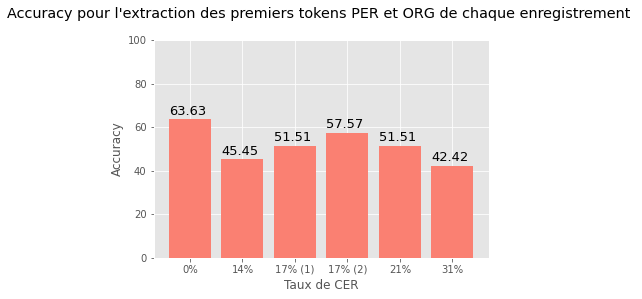

In [48]:
%matplotlib inline
plt.style.use('ggplot')
axes = plt.gca()
axes.set_ylim([0, 100])
x = ['0%', '14%', '17% (1)', '17% (2)', '21%', '31%']
y = [float(str(accuracy_cer_0)[0:5]), float(str(accuracy_cer_14)[0:5]), float(str(accuracy_cer_17)[0:5]), float(str(accuracy_cer_17_2)[0:5]), 
float(str(accuracy_cer_21)[0:5]), float(str(accuracy_cer_31)[0:5])]
x_pos = [i for i, _ in enumerate(x)]

for index,data in enumerate(y):
    plt.text(x=index-0.4, y=data+2, s=f"{data}" , fontdict=dict(fontsize=13))

plt.bar(x_pos, y, color='salmon')
plt.xlabel("Taux de CER")
plt.ylabel("Accuracy")
plt.title("Accuracy pour l'extraction des premiers tokens PER et ORG de chaque enregistrement \n")

plt.xticks(x_pos, x)

plt.show()

## Expérience connexe - Nombre d'entités extraites selon taux de CER

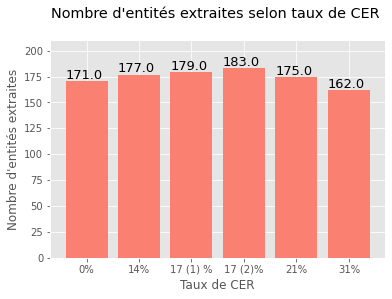

In [49]:
%matplotlib inline
plt.style.use('ggplot')
axes = plt.gca()
axes.set_ylim([0, 210])
x = ['0%', '14%', '17 (1) %', '17 (2)%', '21%', '31%']
y = [float(str(entity_count_cer_0)[0:5]), float(str(entity_count_cer_14)[0:5]), float(str(entity_count_cer_17)[0:5]), float(str(entity_count_cer_17_2)[0:5]), 
float(str(entity_count_cer_21)[0:5]), float(str(entity_count_cer_31)[0:5])]
x_pos = [i for i, _ in enumerate(x)]

for index,data in enumerate(y):
    plt.text(x=index-0.4, y=data+2, s=f"{data}" , fontdict=dict(fontsize=13))

plt.bar(x_pos, y, color='salmon')
plt.xlabel("Taux de CER")
plt.ylabel("Nombre d'entités extraites")
plt.title("Nombre d'entités extraites selon taux de CER \n")

plt.xticks(x_pos, x)

plt.show()